In [20]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [25]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch




In [27]:
df = pd.read_csv("../input/nlp-getting-started/train.csv", encoding="latin-1")



In [28]:

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
df = df.dropna(how="any", axis=1)

In [30]:
df.head(10)

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
5,8,#RockyFire Update => California Hwy. 20 closed...,1
6,10,#flood #disaster Heavy rain causes flash flood...,1
7,13,I'm on top of the hill and I can see a fire in...,1
8,14,There's an emergency evacuation happening now ...,1
9,15,I'm afraid that the tornado is coming to our a...,1


In [31]:
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))


In [32]:
df.head()

,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


In [33]:
len(df[df['target']==0])

4342

In [34]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271])

In [36]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [37]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()


In [38]:
disaster_df = df[df['target'] == 1]['text_len'].value_counts().sort_index()
fake_df = df[df['target'] == 0]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=disaster_df.index,
    y=disaster_df.values,
    name='Real disaster',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=fake_df.index,
    y=fake_df.values,
    name='Fake',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.show()

In [41]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emotions
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [42]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

In [43]:
df['text_clean'] = df['text'].apply(stemm_text)
df.head()


,id,text,target,text_len,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,our deed are the reason of this #earthquak may...
1,4,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask. canada
2,5,All residents asked to 'shelter in place' are ...,1,22,all resid ask to shelter in place are be notif...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,"13,000 peopl receiv #wildfir evacu order in ca..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,just got sent this photo from rubi #alaska as ...


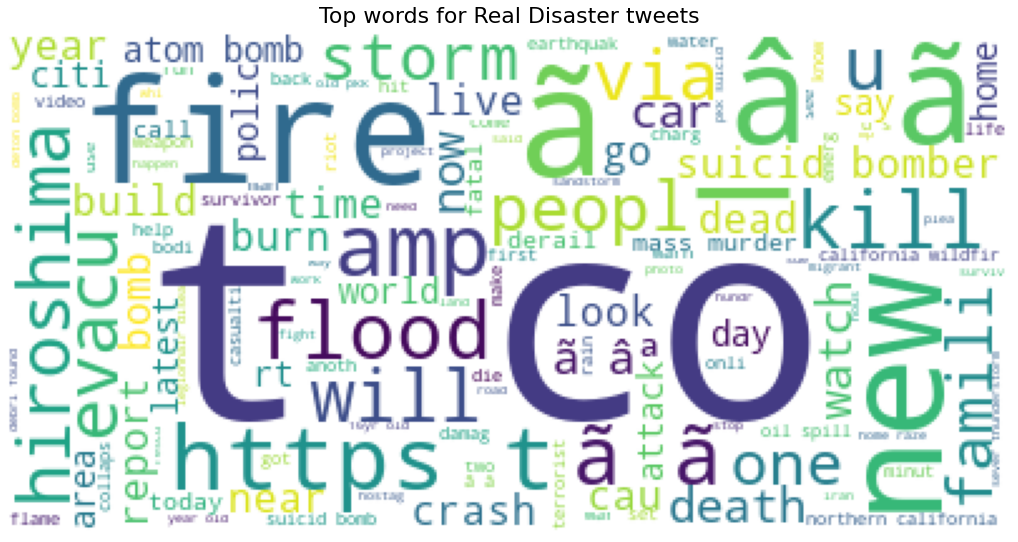

In [44]:

wc = WordCloud(
    background_color='white', 
    max_words=200, 
   )
wc.generate(' '.join(text for text in df.loc[df['target'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Real Disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


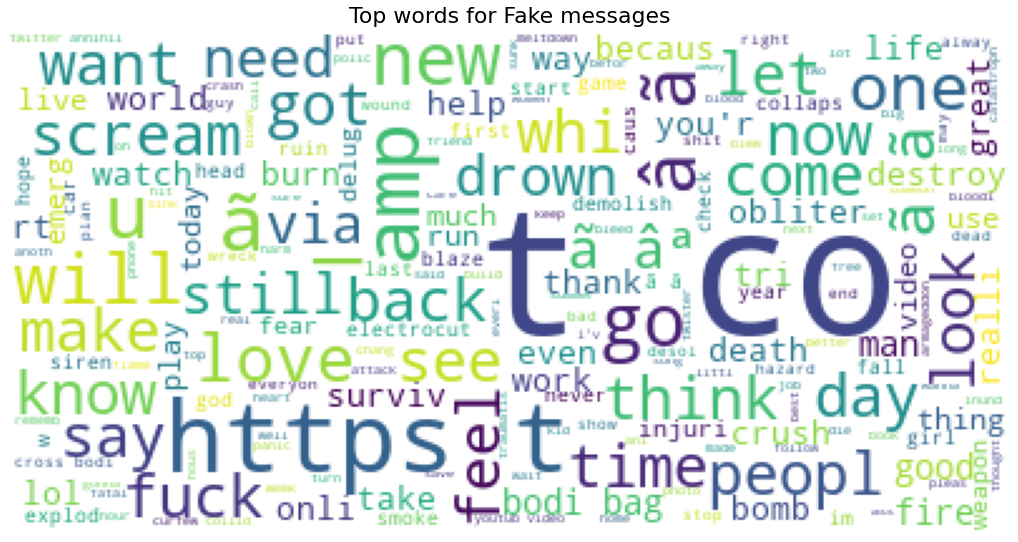

In [45]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
    )
wc.generate(' '.join(text for text in df.loc[df['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [46]:
import plotly.figure_factory as ff

x_axes = ['Real', 'Fake']
y_axes =  ['Fake', 'Real']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                       yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig


In [47]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['text_clean']
y = df['target']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [48]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
    ))
])

In [ ]:
from sklearn import metrics

# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))
print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))


conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))